# Twitter Spam Classification



<img src="finalpicture.PNG">

<i> By Poojitha Nanduri (pnanduri) | Sathwik Chenna (schennam) | Anupam Dewan (adewan) </i> 


## Introduction
With the advent of technology, social media has become inevitable in our lives. Today, it is a mainstream platform for interaction and communication. In recent times, social media has attracted a significant amount of spamming and fake news. Spamming is a phenomenon of spreading unwanted malicious or rather fake information, leading to considerable misunderstanding and misinterpretation.

In this project, we have taken labelled twitter dataset and tried to understand the inherent characteristics of a spam tweet. We have tried to identify the essential features that characterize the spam tweet and classify tweets based on these features. In terms of a machine learning problem, this is a supervised machine learning algorithm that is used for binary classification task (spam or ham). We used different techniques to find out the characteristics that define a tweet as a spam or ham, trained various models based on these derived features and developed a classification model.



## Content

   1.[Data Extraction](#Data-Extraction)
   

   2.[Data Exploration and Feature Engineering](#Data-Exploration-and-Feature-Engineering)
   

   3.[Exploratory Data Analysis and Feature Selection](#Exploratory-Data-Analysis-and-Feature-Selection)
   

   4.[Model Selection](#Model-Selection)
   

   5.[Results](#Results)
   
   
   6.[Conclusion](#Conclusion)


## Data Extraction
we obtained data from external sources. A dataset containing Tweet IDs and labels(spam/ham) was taken from Reddit Datasets for our analysis. This dataset was contributed by PLOS one journal.

Further these Tweet IDs were hydrated using an application called "Hydrator" that in turn uses the Twitter API to scrape the data.

<img src="hydratorimage.png">

#### Importing necessary libraries for Exploratory Data Analysis and Model Building

In [1]:
import pandas as pd
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import math
import nltk
np.set_printoptions(suppress=True)
%matplotlib inline

#### Importing data

In [2]:
df_input_prefiltered = pd.read_csv('spamdata.csv')
df = pd.read_csv('spaminput.csv')

#updating column names to join dataframes on keys
df_input_prefiltered.columns = ['id','label']

#dataframe merge and assign corresponding label
df_input = pd.merge(df, df_input_prefiltered, on=['id'])

In [3]:
ham_df = df_input[df_input.label == 0]
spam_df = df_input[df_input.label == 1]
print("Original length of Spam dataset",len(spam_df))
print("Original length of Ham tweets",len(ham_df))

Original length of Spam dataset 4457
Original length of Ham tweets 62153


## Data Exploration and Feature Engineering

#### Balancing the Dataset
This clearly indicates that the data set is highly unbalanced. This imbalance in data might lead to a high bias and such classification will generally follow a majority rule. Therefore, the dataset was balanced by randomly subsampling same number of ham tweets as spam tweets.

In [4]:
ham_df = ham_df.sample(len(spam_df))
df = pd.concat([ham_df,spam_df]) ## merging the dataframes

In [5]:
print("Number of Spam tweets:",len(spam_df))
print("Number of Ham tweets:",len(ham_df))

Number of Spam tweets: 4457
Number of Ham tweets: 4457


#### Exploring existance of null values 

In [6]:
df.isnull().sum()

coordinates                   8895
created_at                       0
hashtags                      6562
media                         7308
urls                          4371
favorite_count                   0
id                               0
in_reply_to_screen_name       8028
in_reply_to_status_id         8295
in_reply_to_user_id           8028
lang                             0
place                         8768
possibly_sensitive            3521
retweet_count                    0
reweet_id                     6520
retweet_screen_name           6520
source                          95
text                             0
tweet_url                        0
user_created_at                  0
user_screen_name                 0
user_default_profile_image       0
user_description              2383
user_favourites_count            0
user_followers_count             0
user_friends_count               0
user_listed_count                0
user_location                 3638
user_name           

We observe that many features have null values, which need to be removed/manipulated in the dataset. 

By examining the summary statistics of the dataset, features that had high null values such as ‘coordinates’ have been eliminated. Features that are irrelevant in this context, that do not add any value to our analysis, such as ‘language’ or ’screen_name’ were omitted. Features that are based on timestamp were split into elements such as day, date, year, time and added as new features.

Certain features with high number of null values were identified. However, these features were significant features that add value to our analysis. Therefore, in order to make these features more meaningful, new binary features have been created on such features. For certain features like hashtags, where the number of hashtags is significant, continuous variables indicating such values, have been created. This also includes features such as ‘length’, ‘DIGITS’ and ‘CAP’ that indicate the length of the tweet text, number of digits in the tweet text and number of capitalized words in the tweet text respectively. In this way, new binary features and continuous features were created using the existing features with insignificant content.

#### Removing unnecessary labels

In [7]:
print("\nNumber of tweets with null coordinates:",df.coordinates.isnull().sum(),"\nHence, we remove this feature.")

del df['coordinates']


Number of tweets with null coordinates: 8895 
Hence, we remove this feature.


#### Splitting tweet created time & user created time 

In [8]:
print(df.created_at.head(1))

print("\nWe split tweets time stamp into Day, Month, Date, Hour, Min, Sec, Year\n")

11395    Tue May 17 13:59:19 +0000 2016
Name: created_at, dtype: object

We split tweets time stamp into Day, Month, Date, Hour, Min, Sec, Year



In [9]:
df['tweet_day'] = df.created_at.str.split(" ").str[0]
df['tweet_month'] = df.created_at.str.split(" ").str[1]
df['tweet_date'] = df.created_at.str.split(" ").str[2]
df['tweet_time'] = df.created_at.str.split(" ").str[3]
df['tweet_year'] = df.created_at.str.split(" ").str[5]
df = df.reset_index(drop=True)

df.drop(df.index[df[df.lang == 'in'].index[0]],inplace=True)

In [10]:
df['acc_created_day'] = df.user_created_at.str.split(" ").str[0]
df['acc_created_month'] = df.user_created_at.str.split(" ").str[1]
df['acc_created_date'] = df.user_created_at.str.split(" ").str[2]
df['acc_created_time'] = df.user_created_at.str.split(" ").str[3]
df['acc_created_year'] = df.user_created_at.str.split(" ").str[5]

#### New Features

'has_hashtag' is a binary variable. If the tweet was posted along with a hashtag, has_hastag = 1, else 0. <br>
'num_hashtag' is a continous variable. If takes the value corresponding to number of hashtags included in a tweet.

In [11]:
#HASHTAGS FEATURES

df['hashtags']=df['hashtags'].fillna(0)

has_hashtags = []
num_hashtags = []

for i in range(0,len(df)):
    if(df.hashtags.iloc[i] == 0):
        has_hashtags.append(0)
        num_hashtags.append(0)
    else:
        has_hashtags.append(1)
        num_hashtags.append(len(df.hashtags.iloc[i].split(" ")))
    
df['has_hashtags'] = has_hashtags
df['num_hashtags'] = num_hashtags

has_media is a binary variable. If the tweet was posted along with a media link, has_media = 1, else 0

In [12]:
#MEDIA 

df['media'] = df['media'].fillna(0)

has_media = []

for i in range(0,len(df)):
    if(df.media.iloc[i] == 0):
        has_media.append(0)
    else:
        has_media.append(1)

df['has_media'] = has_media

has_urls is a binary variable. If the tweet consists a url link, has_url = 1, else 0 

In [13]:
#URLS

df['urls'] = df['urls'].fillna(0)

has_urls = []

for i in range(0,len(df)):
    if(df.urls.iloc[i] == 0):
        has_urls.append(0)
    else:
        has_urls.append(1)

df['has_urls'] = has_urls

has_favorite_count is a binary variable. If the posted tweet contains a favourite count. <br>
has_favorite_count = 1, else 0 

In [14]:
#favorite_count

has_favorite_count = []

for i in range(0,len(df)):
    if(df.favorite_count.iloc[i] == 0):
        has_favorite_count.append(0)
    else:
        has_favorite_count.append(1)

df['has_favorite_count'] = has_favorite_count

Deleting language label as all the posted tweets are in English 

In [15]:
#lang, as they are all en, we can drop them
del df['lang']

has_place is a binary variable. If the posted tweet contains location details along with it, has_place = 1, else 0

In [16]:
#place

has_place = []

df['place'] = df['place'].fillna(0)

for i in range(0,len(df)):
    if(df.place.iloc[i] == 0):
        has_place.append(0)
    else:
        has_place.append(1)
    
df['has_place'] = has_place

has_retweet_count is a binary variable. If the posted tweet contains retweet count,has_retweet_count = 1, else 0

In [17]:
#retweet_count

has_retweet_count = []

for i in range(0,len(df)):
    if(df.retweet_count.iloc[i] == 0):
        has_retweet_count.append(0)
    else:
        has_retweet_count.append(1)
    
df['has_retweet_count'] = has_retweet_count

is_RT is a binary variable. If the tweet id is a retweet of another tweet, is_RT = 1, else 0

In [18]:
is_RT = []

for i in range(0,len(df)):
    if(df.text.iloc[i][:2] == "RT"):
        is_RT.append(1)
    else:
        is_RT.append(0)
        
df['is_RT'] = is_RT

Similarly, we check if a posted tweet has user description, has a follower count, has a user name, and is verified and created respective binary varaiables. <br>

In [19]:
df['has_user_description']=df.user_description.apply( lambda x: 0 if pd.isnull(x) else 1)
df['has_user_followers_count']=df.user_followers_count.apply( lambda x: 0 if pd.isnull(x) else 1)
df['has_user_listed_count']=df.user_listed_count.apply( lambda x: 0 if pd.isnull(x) else 1)
df['has_user_name']=df.user_name.apply( lambda x: 0 if pd.isnull(x) else 1)
df['is_user_verfied']= df.user_verified.apply(lambda x: 1 if x is True else 0 )

f_ratio: The ratio of followers to following of a person, which is important in analysis Spam/ Ham tweets

In [20]:
df['f_ratio'] = (df['user_followers_count']+1)/(df['user_followers_count']+1 + df['user_friends_count']+1)

length is a continuous variable, corresponding to number of words in a given tweet 

In [21]:
length = []
for i in range(0,len(df)):
    length.append(len(df.iloc[i].text))
df['length'] = length

DIGITS is a continuous variable, corresponds to number of digits in a given tweet

In [22]:
digits_list = []

for i in range(0,len(df)):
    if(sum(c.isdigit() for c in df.text.iloc[i]) == 0):
        digits_list.append(0)
    else:
        digits_list.append(sum(c.isdigit() for c in df.text.iloc[i]))

digits_col = pd.Series(digits_list)
df['DIGITS'] = digits_col.values

CAP is a continuous variable, coreesponds to number of capitalized words in a given tweet.

In [23]:
cap_list = []

for i in range(0,len(df)):
    words = df.text.iloc[i].split()
    count = 0
    for j in range(0,len(words)):
        if(words[j].isupper()):
            count = count + 1;
    cap_list.append(count)    
    #print(cap_list)
        
cap_col = pd.Series(cap_list)
df['CAP'] = cap_col.values

## Exploratory Data Analysis and Feature Selection

As a first step to analysis, Exploratory Data Analysis has been conducted for every feature in the data set. This was used to eliminate highly correlated attributes and select relevant attributes.<br><br>
For continuous attributes, the distribution of the attribute was analyzed ,using Kernel Density Estimate, to visually identify any significant differences in the distribution across each type of tweet. Similarly, for categorical attributes, bar plots of the counts were plotted to visually identify any significant differences in the distribution across each type of tweet.
For the text attribute - tweet text, sentiment analysis was conducted to find polarity distribution and subjectivity distribution across the tweets of each type.<br><br>
For further validation, significance tests such as 2 Sample T-test and Fisher tests were conducted on continuous variables and binary attributes respectively to find the most relevant set of features- a subset of features, which would significantly aid the prediction of the tweet label. These tests were used to statistically justify the feature selection.

### Text Pre-Processing and Basic Text Analysis
First, we take a look at the difference between the tweets corresponding to Spam & Ham. We create new feaures called filtered_text and filtered_text_lower. <br>
filtered_text contains the text of every corresponding tweet, filtered by the nltk stopwords. <br>
filtered_text_lower contains tokens after converting the filtered_text to lower case. 

In [24]:
from nltk.corpus import stopwords
filtered_text = []

for i in range(0,len(df)):
    word_list = str(df.text.iloc[i]).split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_text.append(' '.join(filtered_words))
df['filtered_text'] = filtered_text
df['filtered_text_lower'] = df['filtered_text'].str.lower()

In [25]:
df.columns

Index(['created_at', 'hashtags', 'media', 'urls', 'favorite_count', 'id',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'place', 'possibly_sensitive', 'retweet_count',
       'reweet_id', 'retweet_screen_name', 'source', 'text', 'tweet_url',
       'user_created_at', 'user_screen_name', 'user_default_profile_image',
       'user_description', 'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_listed_count', 'user_location', 'user_name',
       'user_screen_name.1', 'user_statuses_count', 'user_time_zone',
       'user_urls', 'user_verified', 'label', 'tweet_day', 'tweet_month',
       'tweet_date', 'tweet_time', 'tweet_year', 'acc_created_day',
       'acc_created_month', 'acc_created_date', 'acc_created_time',
       'acc_created_year', 'has_hashtags', 'num_hashtags', 'has_media',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_follow

#### Word Frequencies 

In [26]:
spam_text = []
spam_df = df[df.label==1]

for i in range(0,len(spam_df)):
    spam_text.append(spam_df.filtered_text.iloc[i])
    
ham_text = []
ham_df = df[df.label==0]

for i in range(0,len(ham_df)):
    ham_text.append(ham_df.filtered_text.iloc[i])


Below is the plot of 50 most commonly used words in SPAM comment


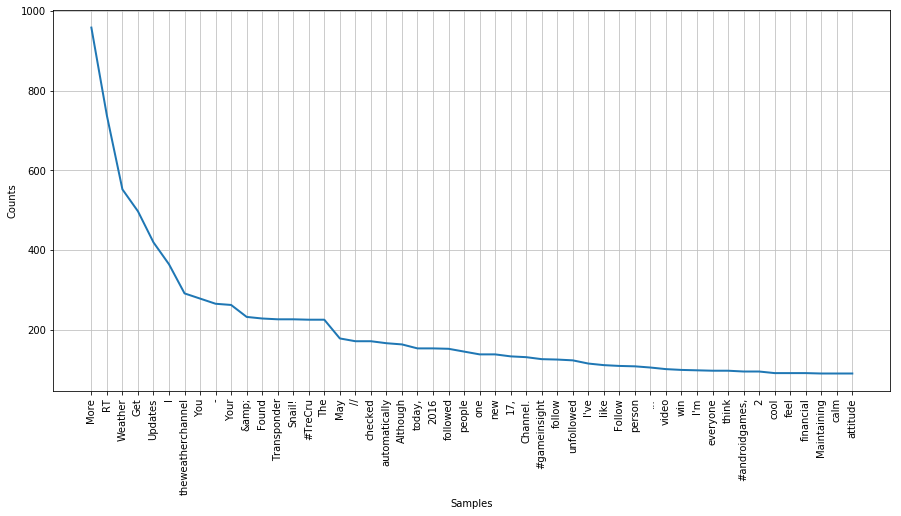


Below is the plot of 50 most commonly used words in HAM comment


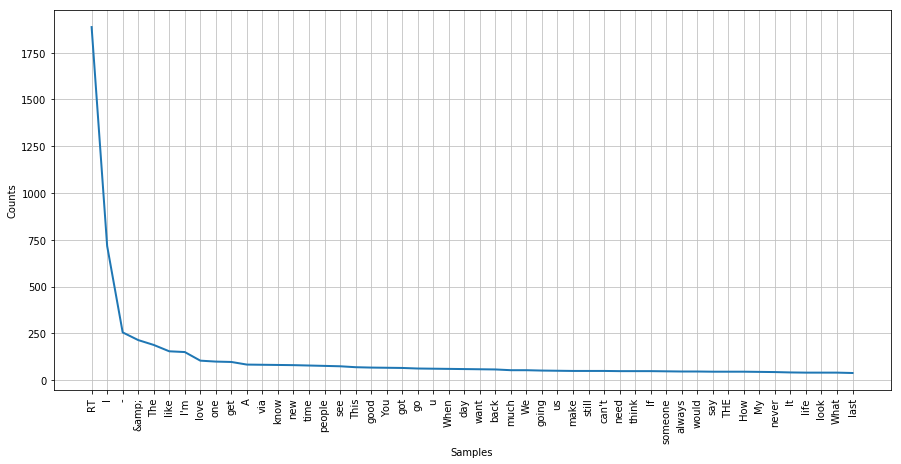

In [27]:
spam_text = ' '.join(spam_text).split()
freq = nltk.FreqDist(spam_text)

print("\nBelow is the plot of 50 most commonly used words in SPAM comment")
plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

ham_text = ' '.join(ham_text).split()
freq = nltk.FreqDist(ham_text)
print("\nBelow is the plot of 50 most commonly used words in HAM comment")

plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

### Word Clouds for Spam corpus

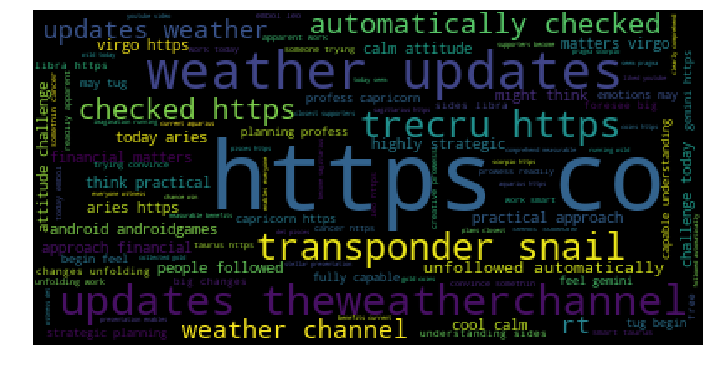

In [28]:
text = ''
for i in range(0,len(spam_df)):
    text = text + str(spam_df.filtered_text_lower.iloc[i])
    
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word Clouds for Ham corpus 

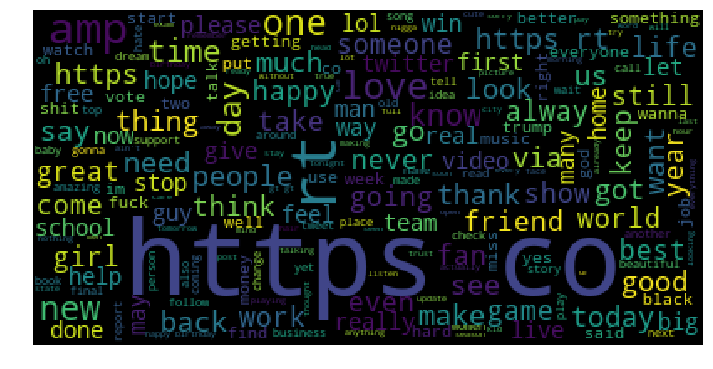

In [29]:
text = ''
for i in range(0,len(ham_df)):
    text = text + str(ham_df.filtered_text_lower.iloc[i])
    
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

It was observed that highly occurring spam words are highly biased towards specific topics, such as ‘weather updates’. However, in case highly frequent ham words, the words were generic and unbiased.

#### Polarity vs Objectivity Sentiment Scores

Sentiment Analysis: the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral. New features using these scores were created.

In [30]:
from textblob import TextBlob

polarity=[]
subjectivity=[]
sentiment_flag=[]
subjectivity_flag=[]
for i in df.filtered_text_lower:
    testimonial = TextBlob(i).sentiment
    polarity.append(testimonial.polarity)
    subjectivity.append(testimonial.subjectivity)
    
    if testimonial.polarity>0.33:
        sentiment_flag.append('positive')
    elif testimonial.polarity<-0.33:
        sentiment_flag.append('negative')
    else:
        sentiment_flag.append('neutral')
        
    if testimonial.subjectivity>0.66:
        subjectivity_flag.append('subjective')
    elif testimonial.subjectivity<0.33:
        subjectivity_flag.append('objective')
    else:
        subjectivity_flag.append('neutral')
            

            
print("The polarity score is a float within the range [-1.0, 1.0]. \nThe subjectivity is a float within the range [0.0, 1.0] \nwhere 0.0 is very objective and 1.0 is very subjective.")            
df['polarity']=pd.Series(polarity)
df['subjectivity']=pd.Series(subjectivity)
df['sentiment_flag']=pd.Series(sentiment_flag)
df['subjectivity_flag']=pd.Series(subjectivity_flag)
df[['polarity','subjectivity','sentiment_flag','subjectivity_flag']].head()

The polarity score is a float within the range [-1.0, 1.0]. 
The subjectivity is a float within the range [0.0, 1.0] 
where 0.0 is very objective and 1.0 is very subjective.


,polarity,subjectivity,sentiment_flag,subjectivity_flag
0,1.000000,0.300000,positive,objective
1,0.000000,0.000000,neutral,objective
2,0.585714,0.840476,positive,subjective
3,0.080000,0.270000,neutral,objective
4,0.525000,0.616667,positive,neutral


#### Overall Sentiment in Spam and Ham

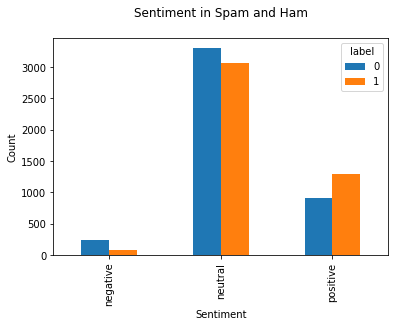

In [31]:
plt.figure(figsize=(10,8))
res= df.groupby(['label','sentiment_flag'])['filtered_text_lower'].count()
res.unstack(level=0).plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment in Spam and Ham\n")
plt.show()

#### Distribution of Polarity value in ham and spam

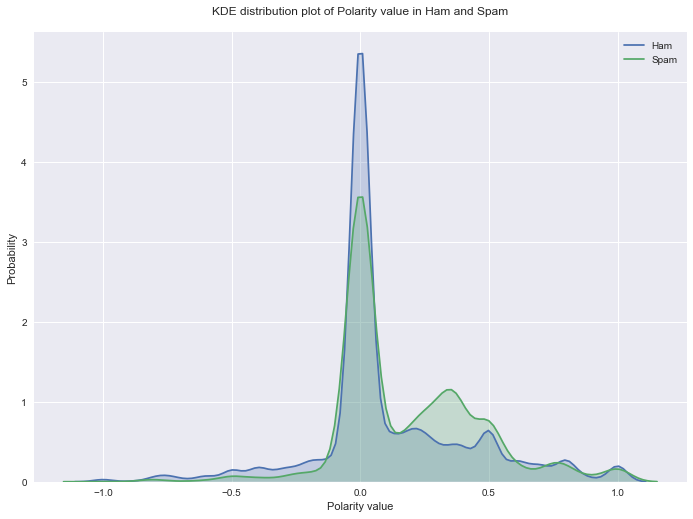

In [32]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
res=[x for x in list(df[df.label==0].polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Ham");
res=[x for x in list(df[df.label==1].polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Spam");
plt.title("KDE distribution plot of Polarity value in Ham and Spam\n")
plt.xlabel("Polarity value")
plt.ylabel("Probability")
plt.show()

#### Distribution of Subjectivity value in ham and spam

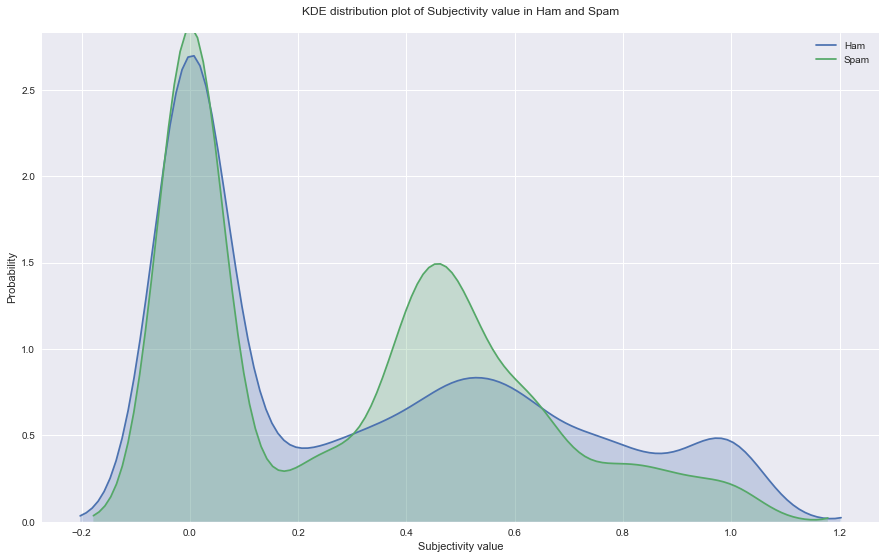

In [33]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15,9)})
res=[x for x in list(df[df.label==0].subjectivity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Ham");
res=[x for x in list(df[df.label==1].subjectivity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Spam");
plt.title("KDE distribution plot of Subjectivity value in Ham and Spam\n")
plt.xlabel("Subjectivity value")
plt.ylabel("Probability")
plt.show()

#### Most Frequent words in positive sentiment spam tweet

In [34]:
text_corpus= ''
import string 

for i in df[df.label==1][df.sentiment_flag=='positive']['filtered_text_lower']:
    text_corpus += i
    
allWords = nltk.tokenize.word_tokenize(text_corpus)
allWordDist = nltk.FreqDist(w.lower() for w in allWords if w not in list(string.punctuation))

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords )
print("Top words in positive sentiment spam tweets")
allWordDist.most_common(10)

D:\Anacondainstallationfolder\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Top words in positive sentiment spam tweets


[('https', 1296),
 ('...', 490),
 ('more', 464),
 ('today', 154),
 ('win', 154),
 ('amp', 129),
 ('rt', 125),
 ('follow', 123),
 ('may', 96),
 ('a', 85)]

#### Most frequent words in negative sentiment spam tweets

In [35]:
text_corpus= ''
for i in df[df.label==1][df.sentiment_flag=='negative']['filtered_text_lower']:
    text_corpus += i
    
allWords = nltk.tokenize.word_tokenize(text_corpus)
allWordDist = nltk.FreqDist(w.lower() for w in allWords if w not in list(string.punctuation))

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords )
print("Top words in negative sentiment spam tweets")
allWordDist.most_common(10)

Top words in negative sentiment spam tweets


D:\Anacondainstallationfolder\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[('https', 115),
 ("'s", 31),
 ('transponder', 20),
 ('snail', 20),
 ('trecru', 20),
 ('lt', 20),
 ('3', 19),
 ('inside', 18),
 ('secret', 14),
 ('...', 13)]

#### Most Frequent words in neutral sentiment spam tweets

In [36]:
text_corpus= ''
for i in df[df.label==1][df.sentiment_flag=='neutral']['filtered_text_lower']:
    text_corpus += i
    
allWords = nltk.tokenize.word_tokenize(text_corpus)
allWordDist = nltk.FreqDist(w.lower() for w in allWords if w not in list(string.punctuation))

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords )
print("Top words in neutral sentiment spam tweets")
allWordDist.most_common(10)

D:\Anacondainstallationfolder\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Top words in neutral sentiment spam tweets


[('https', 2636),
 ('...', 609),
 ('more', 493),
 ('weather', 492),
 ('updates', 368),
 ('theweatherchannel', 251),
 ('i', 250),
 ('the', 178),
 ('may', 165),
 ('today', 162)]

In [37]:
df.columns

Index(['created_at', 'hashtags', 'media', 'urls', 'favorite_count', 'id',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'place', 'possibly_sensitive', 'retweet_count',
       'reweet_id', 'retweet_screen_name', 'source', 'text', 'tweet_url',
       'user_created_at', 'user_screen_name', 'user_default_profile_image',
       'user_description', 'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_listed_count', 'user_location', 'user_name',
       'user_screen_name.1', 'user_statuses_count', 'user_time_zone',
       'user_urls', 'user_verified', 'label', 'tweet_day', 'tweet_month',
       'tweet_date', 'tweet_time', 'tweet_year', 'acc_created_day',
       'acc_created_month', 'acc_created_date', 'acc_created_time',
       'acc_created_year', 'has_hashtags', 'num_hashtags', 'has_media',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_follow

In [38]:
df[['f_ratio','length', 'DIGITS', 'CAP','num_hashtags','user_favourites_count','user_listed_count']].describe()

,f_ratio,length,DIGITS,CAP,num_hashtags,user_favourites_count,user_listed_count
count,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000
mean,0.528529,93.678672,2.785145,0.984293,0.532256,9772.597779,86.366880
std,0.250990,35.812382,3.675846,1.812020,1.199144,29679.669418,553.919158
min,0.001689,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.345218,62.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,0.518623,101.000000,2.000000,0.000000,0.000000,823.000000,5.000000
75%,0.687753,127.000000,4.000000,1.000000,1.000000,7106.000000,29.000000
max,0.999993,188.000000,51.000000,27.000000,13.000000,665368.000000,25408.000000


### Significance-tests 
To find the features which show statistical significance between Ham and Spam classes.

In [39]:
from scipy import stats
np.set_printoptions(suppress=True)

print("t tests for continuous variables")

list_continous_variables=['f_ratio','length', 'DIGITS', 'CAP','num_hashtags','user_favourites_count']

for i in list_continous_variables:
    print("\nVariable name:",i)
    test = stats.ttest_ind(df[i],df['label'], equal_var = False)
    #print(test)
    if test.pvalue<0.05:
        print("The variable",i,"is significant, with a t-stat of",test.statistic)
    else:
        print("The variable",i,"is not significant")

t tests for continuous variables

Variable name: f_ratio
The variable f_ratio is significant, with a t-stat of 4.8234807966

Variable name: length
The variable length is significant, with a t-stat of 245.614045061

Variable name: DIGITS
The variable DIGITS is significant, with a t-stat of 58.1564215747

Variable name: CAP
The variable CAP is significant, with a t-stat of 24.3260168227

Variable name: num_hashtags
The variable num_hashtags is significant, with a t-stat of 2.34799749391

Variable name: user_favourites_count
The variable user_favourites_count is significant, with a t-stat of 31.0842719745


In [40]:
df = df[['label','has_hashtags', 'num_hashtags', 'has_media','user_favourites_count',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_followers_count',
       'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
       'length', 'DIGITS', 'CAP', 'filtered_text', 'filtered_text_lower','user_listed_count']]

#### Distribution plot for number of digits that occured in a tweet, based on Spam/ Ham label

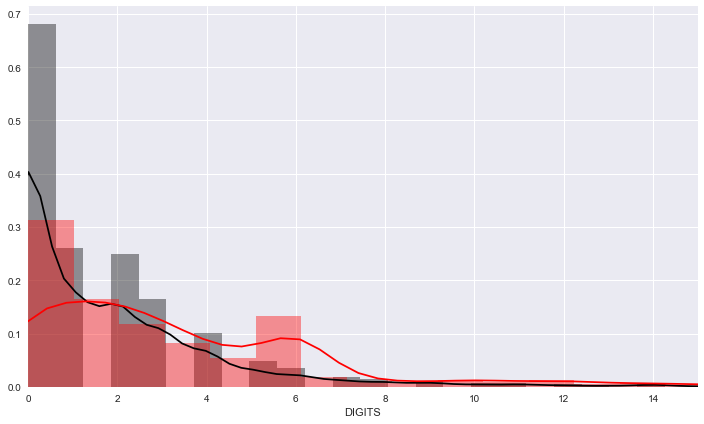

In [41]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].DIGITS,color="black",kde=True)
sns.distplot(df[df.label==1].DIGITS,color="red",kde=True)
plt.xlim(0,15)
plt.show()

#### Distribution plot for number of capitalized words that occured in a tweet, based on Spam/ Ham label 

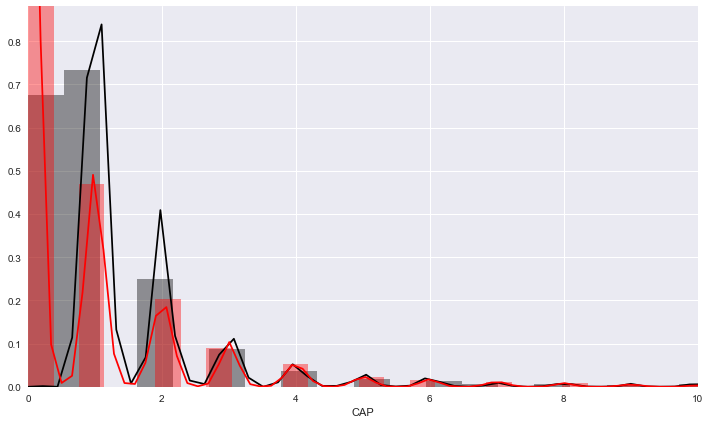

In [42]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].CAP,color="black",kde=True)
sns.distplot(df[df.label==1].CAP,color="red",kde=True)
plt.xlim(0,10)
plt.show()

####  Distribution plot for f_ratio of a user, based on Spam/ Ham label

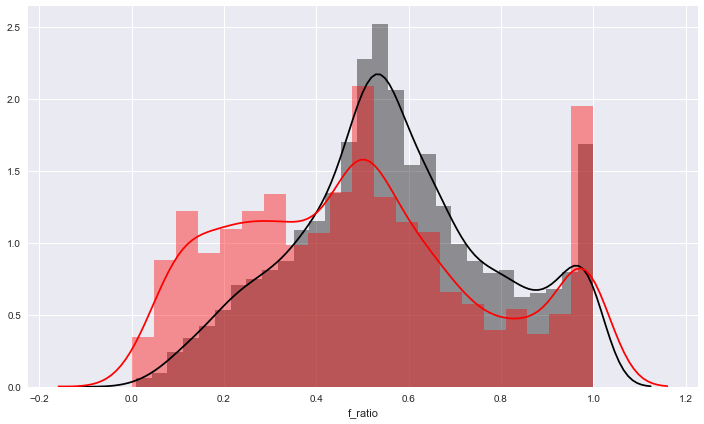

In [43]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].f_ratio,color="black",kde=True)
sns.distplot(df[df.label==1].f_ratio,color="red",kde=True)
plt.show()

#### Distribution plot for number of hashtags in a tweet, based on Spam/ Ham labe 

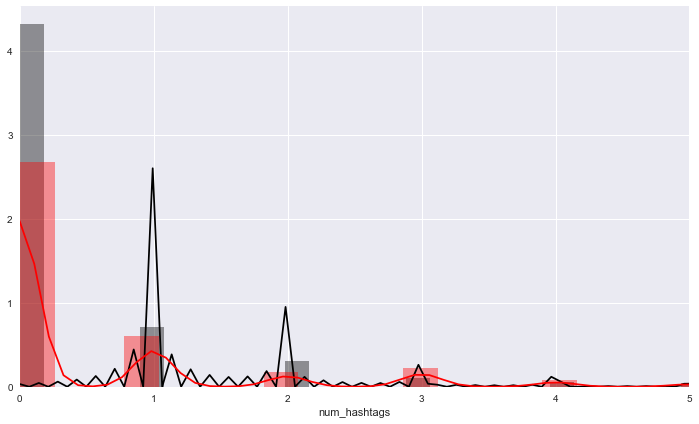

In [44]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].num_hashtags,color="black",kde=True)
sns.distplot(df[df.label==1].num_hashtags,color="red",kde=True)
plt.xlim(0,5)
plt.show()

#### Distribution plot for number of times a user liked a tweet, based on Spam/ Ham label

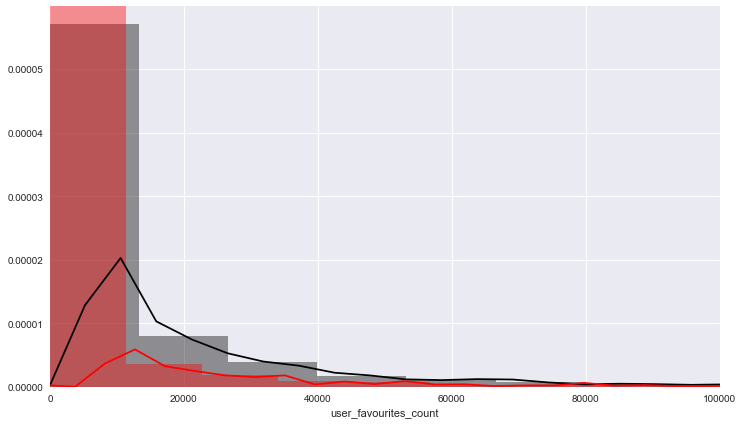

In [45]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].user_favourites_count,color="black",kde=True)
sns.distplot(df[df.label==1].user_favourites_count,color="red",kde=True)
plt.xlim(0,100000)
plt.show()

#### Distribution plot of Length of tweets, based on the Spam or Ham label 

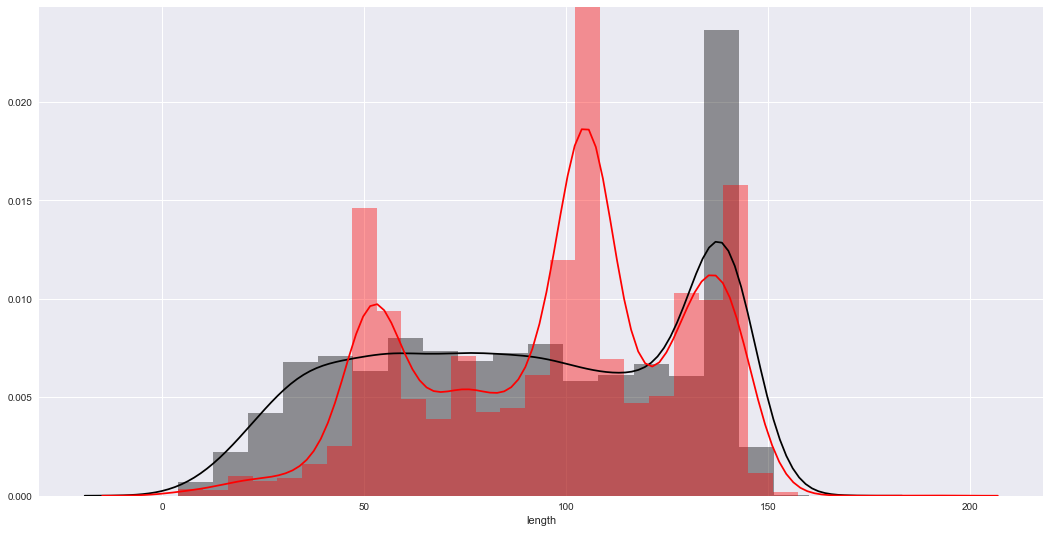

In [46]:
plt.figure(figsize=(18,9))
sns.distplot(df[df.label==0].length,color="black",kde=True)
sns.distplot(df[df.label==1].length,color="red",kde=True)
plt.show()

#### Distribution plot of count of number of lists user is mentioned in, based on the Spam or Ham label 

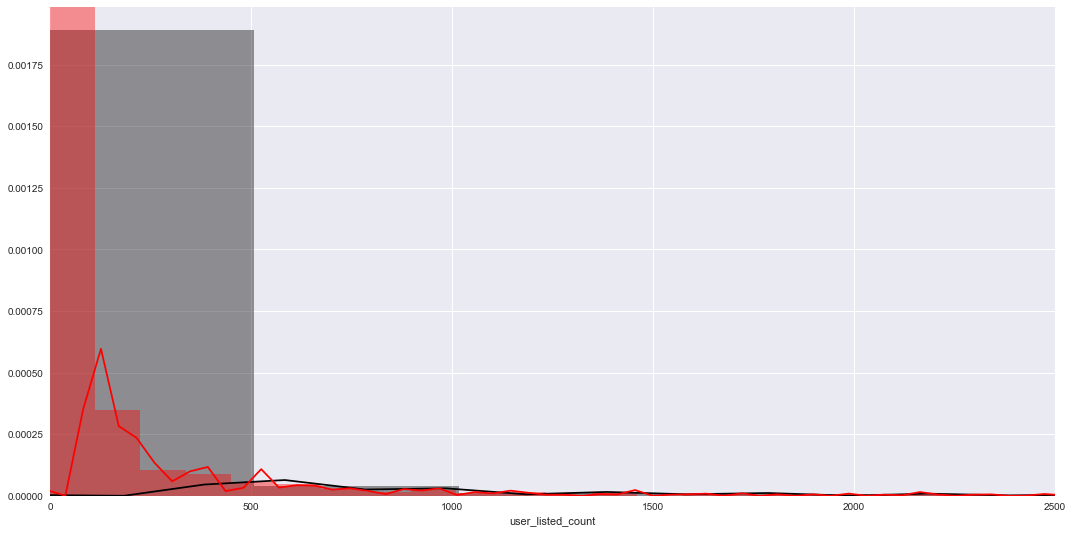

In [47]:
plt.figure(figsize=(18,9))
sns.distplot(df[df.label==0].user_listed_count,color="black",kde=True)
sns.distplot(df[df.label==1].user_listed_count,color="red",kde=True)
plt.xlim(0,2500)
plt.show()

Count plot for ' has_hashtags ' feature, based on Spam/ Ham tweet label


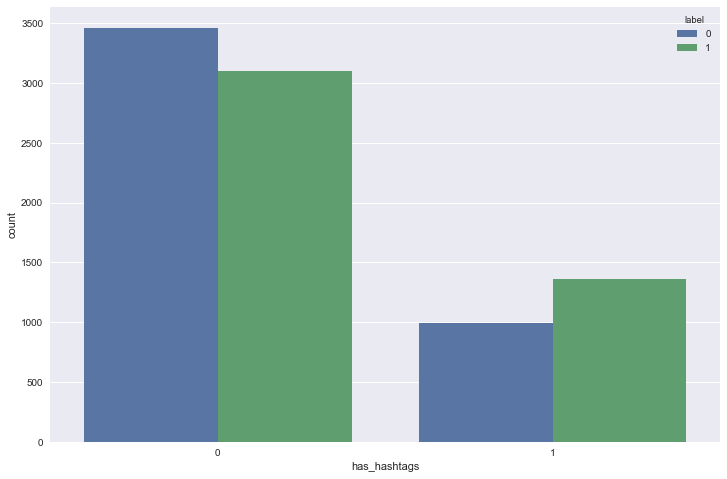



Count plot for ' num_hashtags ' feature, based on Spam/ Ham tweet label


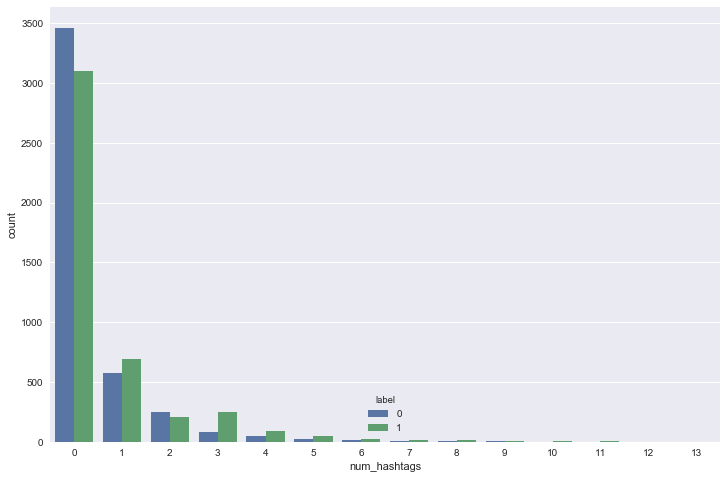



Count plot for ' has_media ' feature, based on Spam/ Ham tweet label


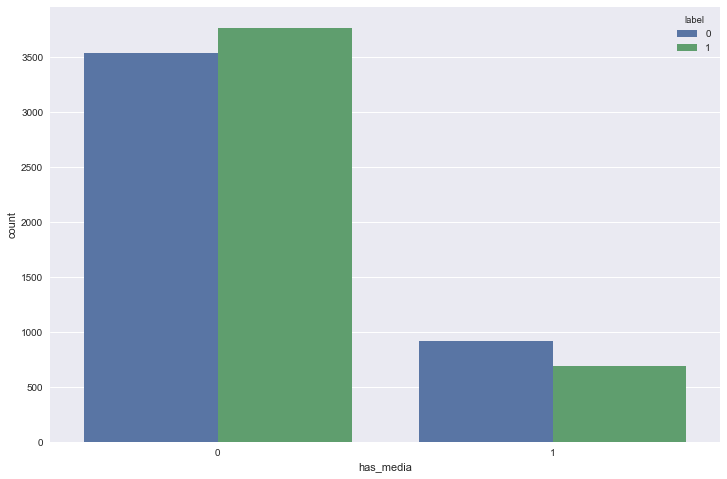



Count plot for ' has_urls ' feature, based on Spam/ Ham tweet label


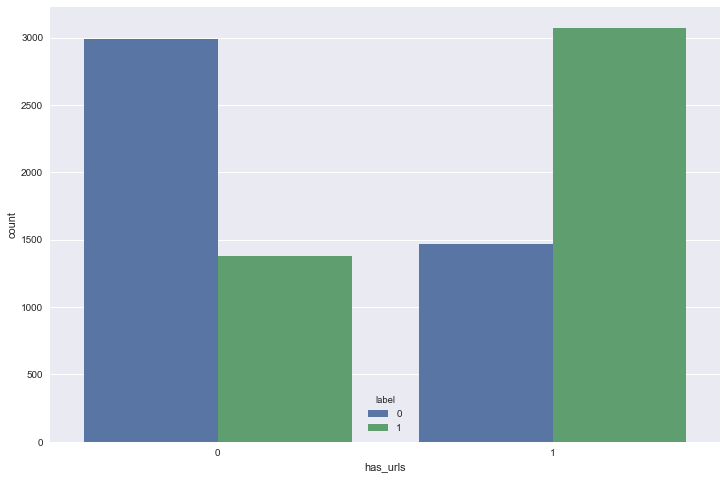



Count plot for ' has_favorite_count ' feature, based on Spam/ Ham tweet label


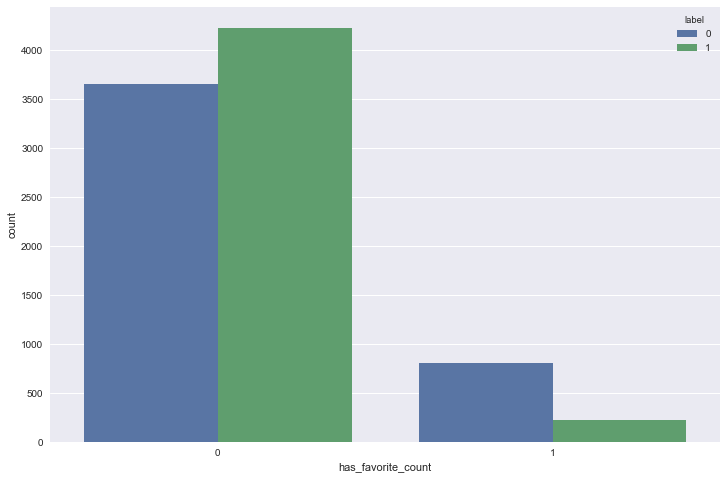



Count plot for ' has_place ' feature, based on Spam/ Ham tweet label


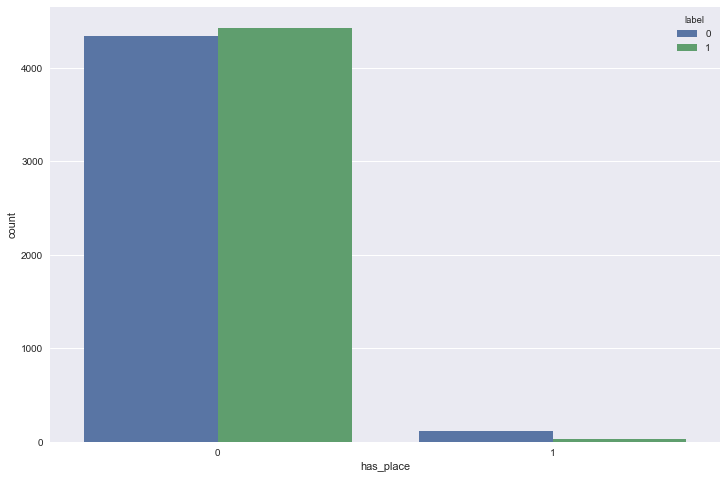



Count plot for ' has_retweet_count ' feature, based on Spam/ Ham tweet label


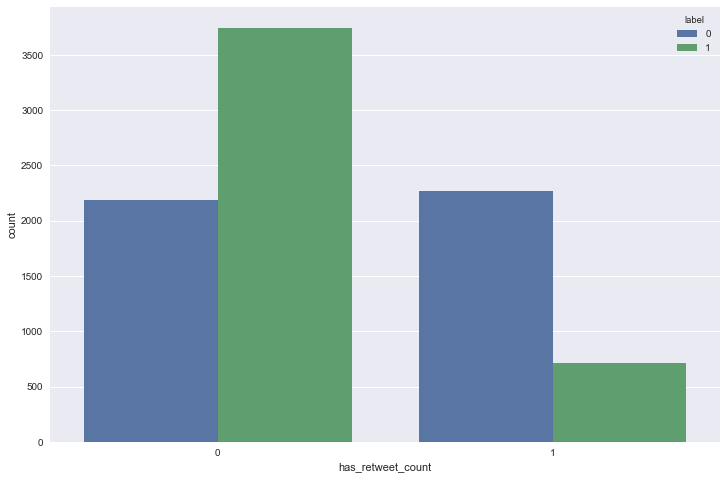



Count plot for ' is_RT ' feature, based on Spam/ Ham tweet label


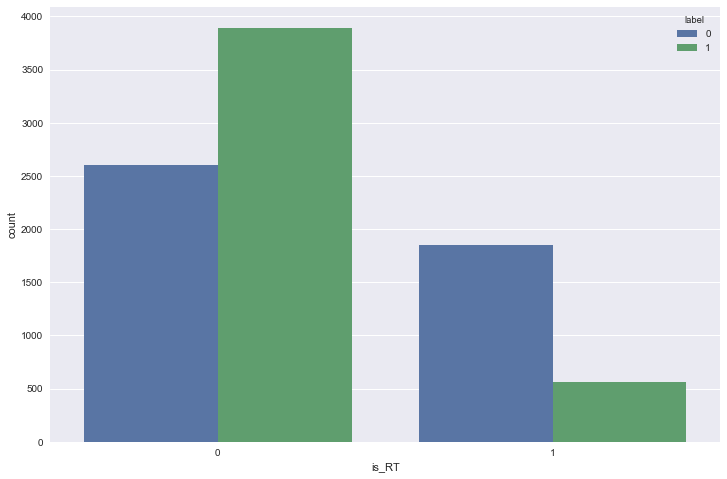



Count plot for ' has_user_description ' feature, based on Spam/ Ham tweet label


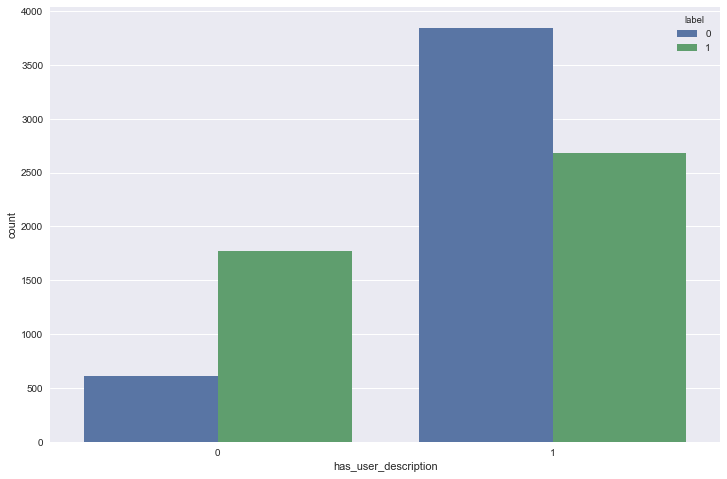



Count plot for ' has_user_name ' feature, based on Spam/ Ham tweet label


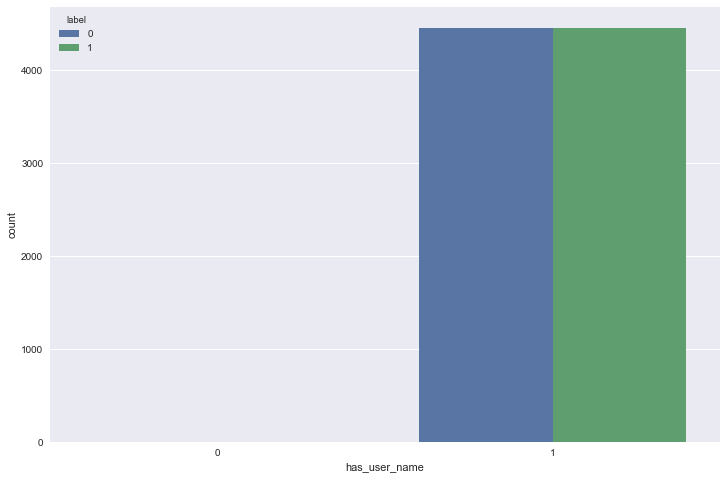



Count plot for ' is_user_verfied ' feature, based on Spam/ Ham tweet label


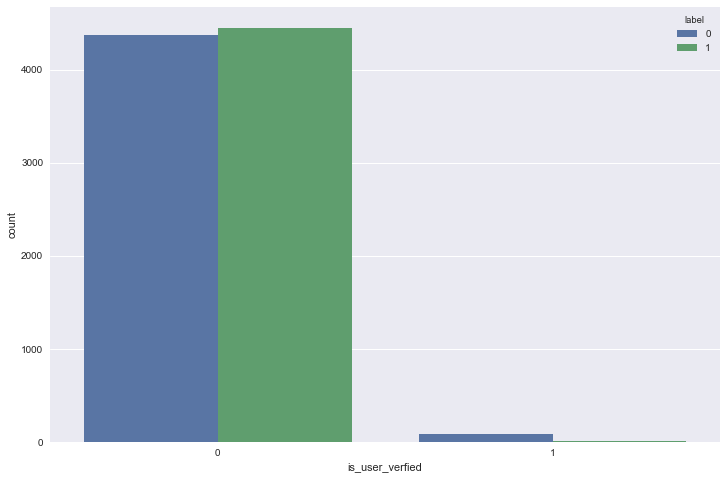



Count plot for ' DIGITS ' feature, based on Spam/ Ham tweet label


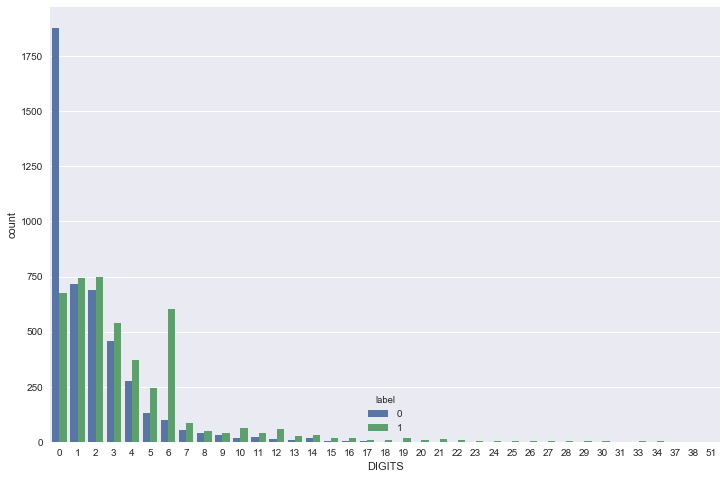



Count plot for ' CAP ' feature, based on Spam/ Ham tweet label


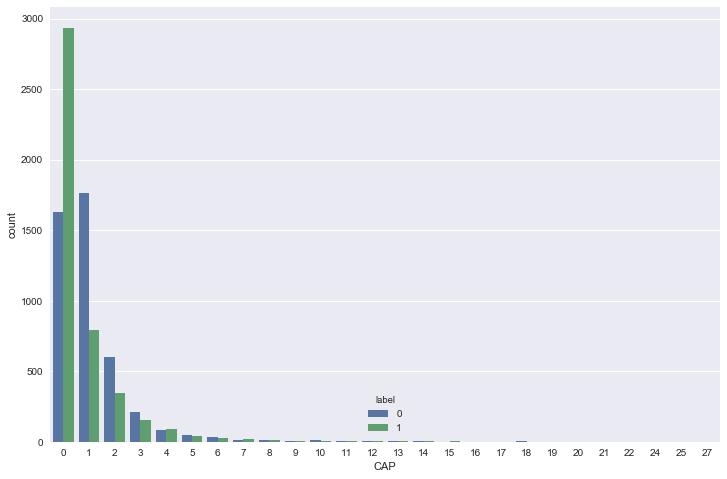

In [48]:
cols = ['label', 'has_hashtags', 'num_hashtags', 'has_media', 'has_urls',
       'has_favorite_count', 'has_place', 'has_retweet_count', 'is_RT',
       'has_user_description',  'has_user_name',
        'is_user_verfied',
        'DIGITS', 'CAP']

for i in range(1,len(cols)):
    plt.figure(figsize=(12,8))
    c = cols[i]
    print("Count plot for","'",cols[i],"' feature, based on Spam/ Ham tweet label")
    sns.countplot(c,hue=df.label,data=df)
    plt.show()
    print("\n")

# Model Selection

We implemented models using
1. Text Based Features
2. Account Based Features along with Features obtained from text. 

### 1. Naive Bayes Model

We run a Naive Bayes classifier, purely based on tweet text. This model is constructed by using Count Vectorizer from sklearn, with attributes accounting to whether a unique word exists in a tweet or not (given by 1 and 0 respectively).

In [49]:
NB_df = df[['filtered_text_lower','label']]
NB_df = NB_df.sample(frac=1)

from sklearn.feature_extraction.text import CountVectorizer

vecfinal = CountVectorizer(min_df=50,max_df=0.8,stop_words="english")
finalX = vecfinal.fit_transform(NB_df['filtered_text_lower'])

Splitting into training and testing data 

In [50]:
X_train = finalX.toarray()[:4000]
X_test = finalX.toarray()[4000:len(finalX.toarray())]
y_train = NB_df.label[:4000]
y_test = NB_df.label[4000:len(NB_df)]

In [51]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)
ypred = clf_nb.predict(X_test)
accuracy = f1_score(y_test, ypred, average='weighted')
print("Accuracy for this model: ", accuracy*100,"%")

Accuracy for this model:  79.0465562654 %


In [52]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[2389   87]
 [ 912 1525]] 



In [53]:
TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")


# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

True Positive Rate 72.37 %
True Negative Rate 94.6 %
Positive Predictive Value 96.49 %
Negative Predictive Value 62.58 %
False Positive Rate 5.4 %
False Negative Rate 27.63 %
False Discovery Rate 3.51 %
Overall Accuracy 79.67 %


Below are the AUC & ROC's of the Bernoulli Naive Bayes model.

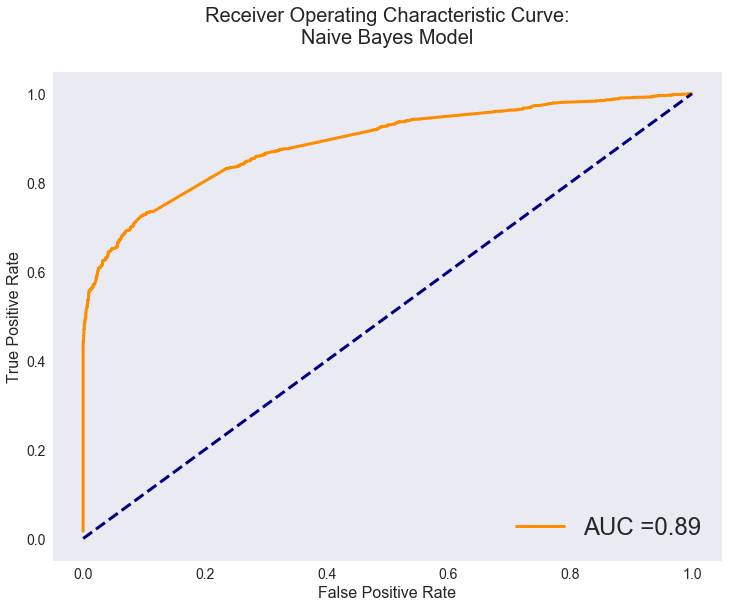

In [54]:
large = 24

from sklearn import metrics
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn = clf_nb.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

naive_bayes_model_object={}
naive_bayes_model_object['fpr']=fpr
naive_bayes_model_object['tpr']=tpr
naive_bayes_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nNaive Bayes Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

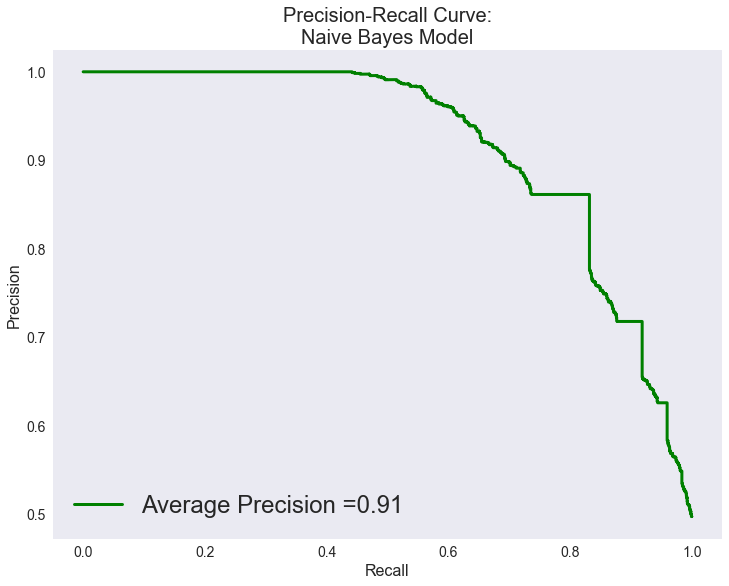

In [55]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


y_pred_proba_nb=clf_nb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nb)
average_precision = average_precision_score(y_test, y_pred_proba_nb)

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

naive_bayes_model_object['recall']=recall
naive_bayes_model_object['precision']=precision
naive_bayes_model_object['average_precision']=average_precision

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nNaive Bayes Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

Though the accuracy rate of this model is considerably significant, according to the confusion matrix, the number of false positives, i.e., the tweets that are actually spam but are misclassified as ham are significantly high.

#### Models using non-text based (account-based) features work for prediction 

We subset only necessary features which make sense in this scenario, i.e., features that statistically differentiate between spam and ham tweets.

In [56]:
y = df.label
X = df[['has_hashtags', 'num_hashtags', 'has_media','user_favourites_count',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_followers_count',
       'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
       'length', 'DIGITS', 'CAP','user_listed_count']]
model = X

### 2. Decision Tree Classifier 

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(model, y, test_size = 0.5)

depth = []
training_score = []
testing_score = []

for i in range(1,25):
    clf = DecisionTreeClassifier(criterion = "gini")
    clf.max_depth = i
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    #print("Training accuracy, with",i,"depth :",accuracy_score(pred_train,y_train)*100)
    
    clf.fit(X_train, y_train)
    pred_test = clf.predict(X_test)
    #print("Testing accuracy, with",i,"depth :",accuracy_score(pred_test,y_test)*100,"\n")
    
    depth.append(i)
    training_score.append(accuracy_score(pred_train,y_train))
    testing_score.append(accuracy_score(pred_test,y_test))

D:\Anacondainstallationfolder\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


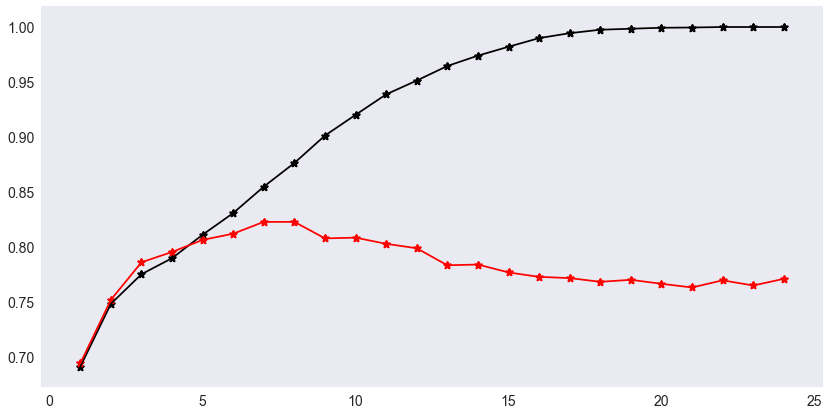

In [58]:
plt.figure(figsize=(14,7))
plt.grid()

plt.plot(depth, training_score,c='black')
plt.plot(depth, testing_score,c='red')
plt.scatter(depth, training_score,c='black',marker='*',linewidth=2)
plt.scatter(depth, testing_score,c='red',marker='*',linewidth=2)

We observe that the model predicts well for a maximum tree depth from 6 to 9, with accuracy of around 81 %

In [59]:
from pandas.compat import StringIO
from sklearn import tree
import pydotplus


dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("train.pdf") 

from IPython.display import IFrame
IFrame("train.pdf", width=900, height=450)

### Hyperparameter Tuning using Grid Serach 

In [60]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

X = model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
    
clf = DecisionTreeClassifier()
 
param_grid = {
              "criterion": ["gini", "entropy"],
              "max_depth": list(np.arange(1,50,1)),
              }
 
CLF = GridSearchCV(estimator = clf, param_grid=param_grid, cv = 5)
CLF.fit(X_train, y_train)

D:\Anacondainstallationfolder\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

The best parameters are as follows: 

In [61]:
CLF.best_params_

{'criterion': 'entropy', 'max_depth': 5}

Now, we fit a new model with the best parameters 

In [62]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=7)
clf.fit(X_train,y_train)
ypred = clf.predict(X_test)
print("Prediction Accuracy:",accuracy_score(ypred,y_test)*100,"%")

Prediction Accuracy: 79.784608481 %


In [63]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1944  306]
 [ 595 1612]] 



In [64]:
TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")


# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

True Positive Rate 76.57 %
True Negative Rate 84.05 %
Positive Predictive Value 86.4 %
Negative Predictive Value 73.04 %
False Positive Rate 15.95 %
False Negative Rate 23.43 %
False Discovery Rate 13.6 %
Overall Accuracy 79.78 %


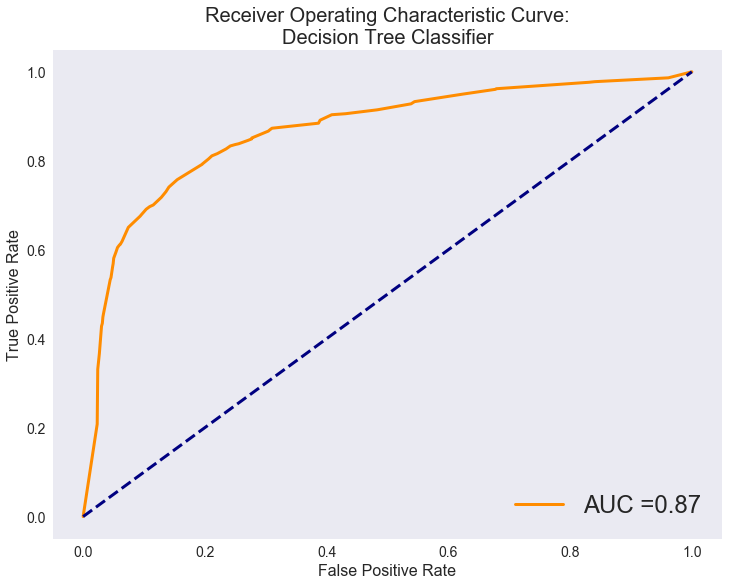

In [66]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn =clf.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

dt_model_object={}
dt_model_object['fpr']=fpr
dt_model_object['tpr']=tpr
dt_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nDecision Tree Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

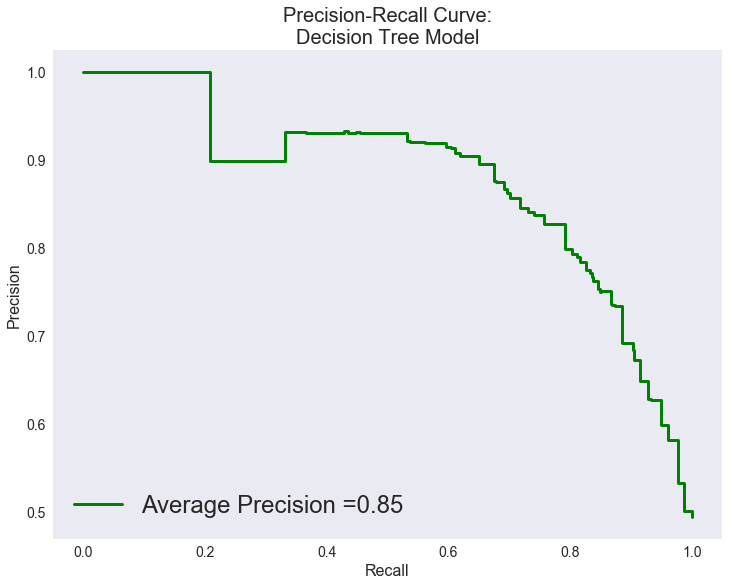

In [67]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_dt =clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_dt)
average_precision = average_precision_score(y_test, y_pred_proba_dt)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
dt_model_object['recall']=recall
dt_model_object['precision']=precision
dt_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nDecision Tree Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

In order to make use of all the other account-based features in our prediction task, Decision Tree model was implemented. The hyper-parameter of the decision Tree classifier - maximum depth of the tree, was tuned to achieve maximum accuracy of around 81%, using Grid Search Cross Validation to tune hyper-parameters.

### 3. KNN model

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

X = model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
    
neigh = KNeighborsClassifier()

k = np.arange(20)+1
param_grid = {'n_neighbors': k}
                                  
CLF = GridSearchCV(estimator = neigh, param_grid = param_grid, cv = 5)
CLF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [69]:
CLF.best_params_

{'n_neighbors': 6}

In [70]:
neigh = KNeighborsClassifier(n_neighbors = 6)
neigh.fit(X_train,y_train)
ypred = CLF.predict(X_test)
accuracy_score(ypred,y_test)*100

70.76508862463541

In [71]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1755  440]
 [ 863 1399]] 



In [72]:
TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]
print(TP,FP,FN,TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")


# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

1755 440 863 1399
True Positive Rate 67.04 %
True Negative Rate 76.07 %
Positive Predictive Value 79.95 %
Negative Predictive Value 61.85 %
False Positive Rate 23.93 %
False Negative Rate 32.96 %
False Discovery Rate 20.05 %
Overall Accuracy 70.77 %


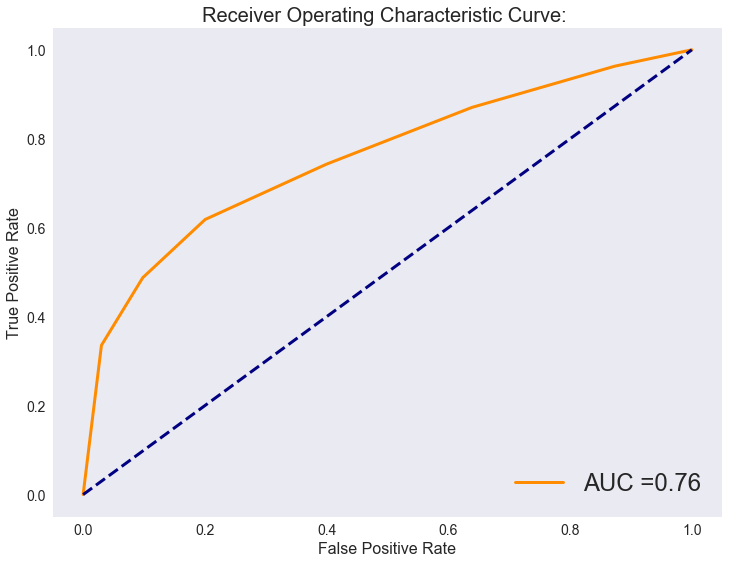

In [73]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn = neigh.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

knn_model_object={}
knn_model_object['fpr']=fpr
knn_model_object['tpr']=tpr
knn_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: ')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

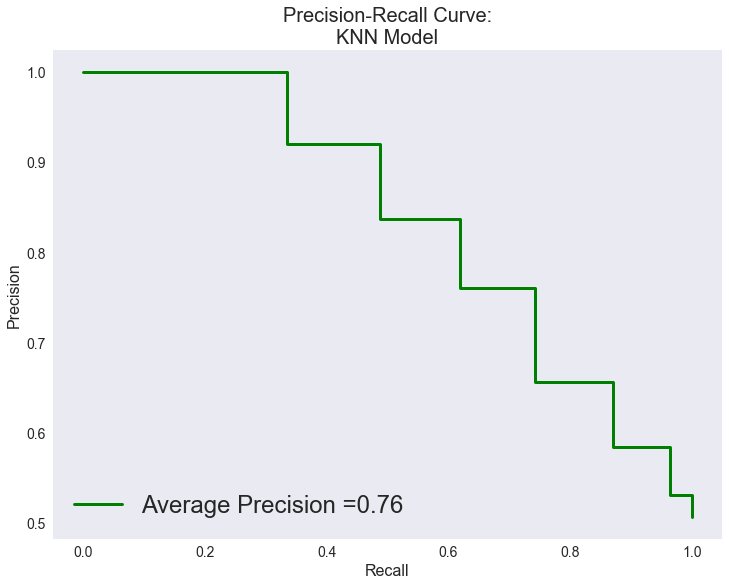

In [74]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_knn = neigh.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_knn)
average_precision = average_precision_score(y_test, y_pred_proba_knn)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
knn_model_object['recall']=recall
knn_model_object['precision']=precision
knn_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nKNN Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

Making use of all the account-based features, a KNN model was implemented using the Grid Search Cross Validation. Using the best parameter obtained from this process, the accuracy was 70%.

### 4. Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

rfc.fit(X_train,y_train)
ypred = rfc.predict(X_test)
print("Prediction Accuracy:",accuracy_score(ypred,y_test)*100,"%")

Prediction Accuracy: 82.2975095356 %


In [76]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1930  268]
 [ 521 1738]] 



In [77]:
TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")


# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

True Positive Rate 78.74 %
True Negative Rate 86.64 %
Positive Predictive Value 87.81 %
Negative Predictive Value 76.94 %
False Positive Rate 13.36 %
False Negative Rate 21.26 %
False Discovery Rate 12.19 %
Overall Accuracy 82.3 %


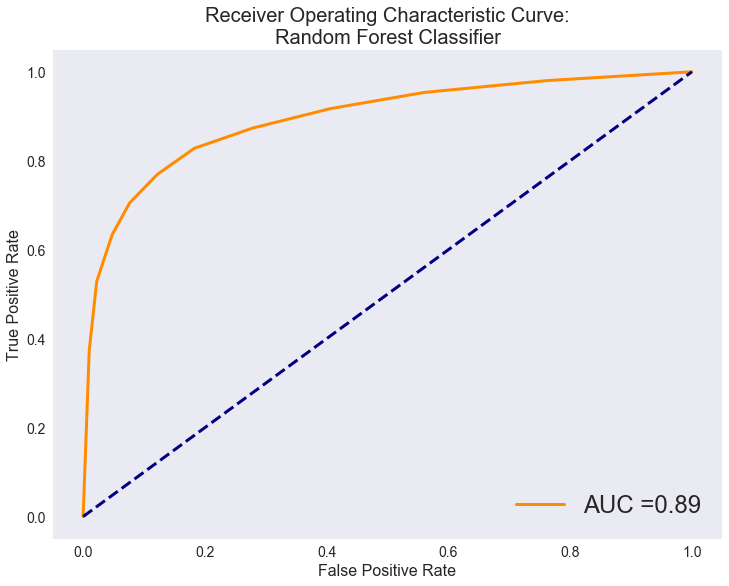

In [78]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rfc)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rfc)

rfc_model_object={}
rfc_model_object['fpr']=fpr
rfc_model_object['tpr']=tpr
rfc_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nRandom Forest Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

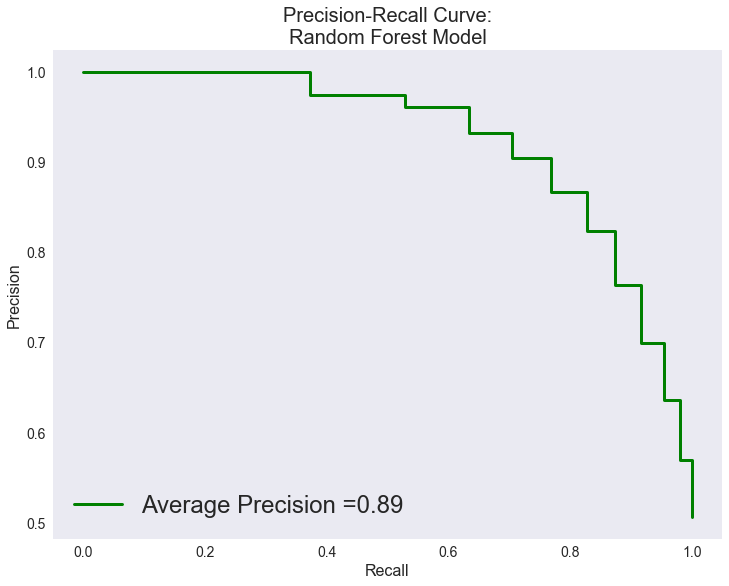

In [79]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rfc)
average_precision = average_precision_score(y_test, y_pred_proba_rfc)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
rfc_model_object['recall']=recall
rfc_model_object['precision']=precision
rfc_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nRandom Forest Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

In [80]:
rfc.feature_importances_

array([ 0.0136259 ,  0.02750981,  0.01569176,  0.19941574,  0.07882236,
        0.01562446,  0.0030018 ,  0.03454798,  0.02382043,  0.03976221,
        0.        ,  0.        ,  0.00023143,  0.00142313,  0.11132495,
        0.15401525,  0.111097  ,  0.05518074,  0.11490506])

In order to further improve the accuracy of the model and avoid overfitting, Random Forest Classifier was implemented. Random forest classifiers in general tend to reduce the variance by training the model on different samples of data. As a result, an improved accuracy score of 83.5% was achieved using this classifier. <br>


## Model Evaluation Metrics

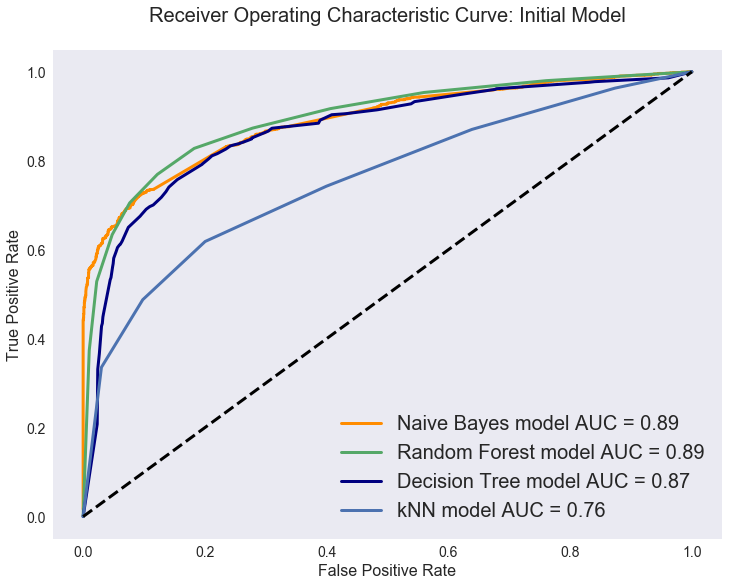

In [81]:
large = 20

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))


plt.plot(naive_bayes_model_object['fpr'],naive_bayes_model_object['tpr'],label="Naive Bayes model AUC = "+str(round(naive_bayes_model_object['auc'],2)), lw=3,color='darkorange')

plt.plot(rfc_model_object['fpr'],rfc_model_object['tpr'],label="Random Forest model AUC = "+str(round(rfc_model_object['auc'],2)), lw=3,color='g')



plt.plot(dt_model_object['fpr'],dt_model_object['tpr'],label="Decision Tree model AUC = "+str(round(dt_model_object['auc'],2)), lw=3,color='navy')
plt.plot(knn_model_object['fpr'],knn_model_object['tpr'],label="kNN model AUC = "+str(round(knn_model_object['auc'],2)), lw=3,color='b')


plt.plot([0, 1], [0, 1], color='black', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: Initial Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

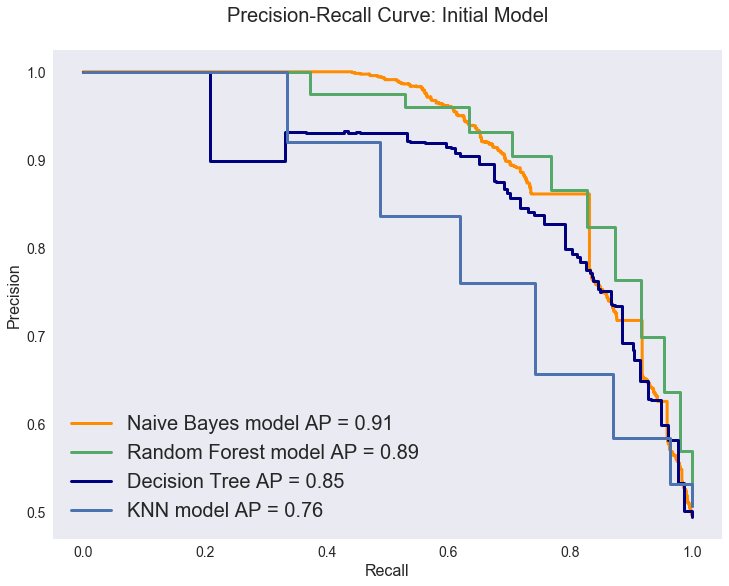

In [82]:
large = 20

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))



plt.step(naive_bayes_model_object['recall'], naive_bayes_model_object['precision'], color='darkorange',label="Naive Bayes model AP = "+str(round(naive_bayes_model_object['average_precision'],2)),lw=3)
plt.step(rfc_model_object['recall'], rfc_model_object['precision'], color='g',label="Random Forest model AP = "+str(round(rfc_model_object['average_precision'],2)),lw=3)
plt.step(dt_model_object['recall'], dt_model_object['precision'], color='navy',label="Decision Tree AP = "+str(round(dt_model_object['average_precision'],2)),lw=3)
plt.step(knn_model_object['recall'], knn_model_object['precision'], color='b',label="KNN model AP = "+str(round(knn_model_object['average_precision'],2)),lw=3)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Initial Model\n')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

## Results

The final results are as follows:

|   Model          | Accuracy %  | 
|------------------|-------------|
|   Naive Bayes    | 78.86       | 
|   Decision Tree  | 80.5        | 
|   KNN            | 71.28       | 
|   Random Forest  | 83.3        | 


In conclusion, Random Forest model gives better performance in terms of accuracy among the considered models.

## Conclusion 


The project aimed at finding a way to analyze the inherent nature of Tweets and model a robust classifier that could help in classifying if a tweet is spam or a ham.We started by extracting the tweets-ids from the twitter dataset, hydrating it to get the corrosponding tweets related to those tweet-ids, applying class balancing techniques to make a balanced data.
Furthermore, once with data we did some EDA to understand the textual context and the features and their important correlation with a tweet being spam or ham.We did some feature selection using significance test and came up with list of features of high importance and major drivers towards the problem at hand.

Finally then, we jumped to implement various models such as Bayes Classifier(Base Model),Logistic regression(due to its easy interpretibility), descion trees(due to its easy and non-linear classification characteristics) and finally Random Forest(due to being emnseble techniques).We coupled these models with appropriate cross validation techniques and hyperparamter tuning to finally evaluate the performance of the data on test data.

We observed that Random Forest perfromed the best in classifying the tweets being spam or ham with a high accuracy of 83%. The high accuracy could be attributed to reason such as being a randoimized ensemble method whcih result in the model having low bias and variance and as a result performs better

## References

1. Dataset resources: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182487
https://www.reddit.com/r/datasets/comments/6ypl7s/twitter_spam_dataset_needed/ <br>

2. https://pdfs.semanticscholar.org/cf55/b793da1815a796e69cba814c580063165dc2.pdf <br>

3. Hydrator - https://github.com/DocNow/hydrator <br>

4. https://pdfs.semanticscholar.org/cf55/b793da1815a796e69cba814c580063165dc2.pdf <br>